<a href="https://colab.research.google.com/github/LiliyaIvanova/ML-regression/blob/main/Dataset_Medical_Insurance_Cost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

In [ ]:
data = pd.read_csv('insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Показатели (признаки) данного датасета: 

1 - возраст получателя; 

2 - пол; 

3 - ИМТ - индекс массы тела (дает представление о телосложении, весе, относительно высоком или низком по отношению к росту, объективный индекс массы тела (кг/м^2) с использованием отношения роста к весу, в идеале от 18,5 до 24,9);

4 - дети (количество иждевенцев);

5 - курит (да/нет) 

6 - регион (жилой район в США, северо-восток, юго-восток, юго-запад, северо-запад) 

7 - стоимость страхового взноса - целевой признак. 

Посмотрим, как эти факторы влияют на стоимость страхового взноса по медицинскому страхованию. 

# Предварительная обработка данных и их анализ

In [ ]:
data.shape

(1338, 7)

In [ ]:
# count missing values 
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Отсутствующих значений нет. 

In [ ]:
# dataset description
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Средний возраст страхователя 39 лет, самому молодому - 18 лет, самому возрастному - 64 года. 

In [ ]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


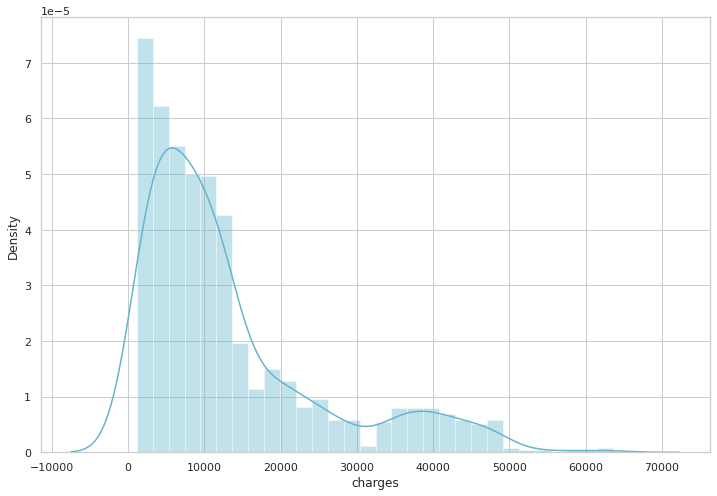

In [ ]:
# distribution schedule of Charges 
sns.set(style='whitegrid')
f, ax = plt.subplots(1,1, figsize=(12, 8))
ax = sns.distplot(data.charges, kde = True, color = 'c')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


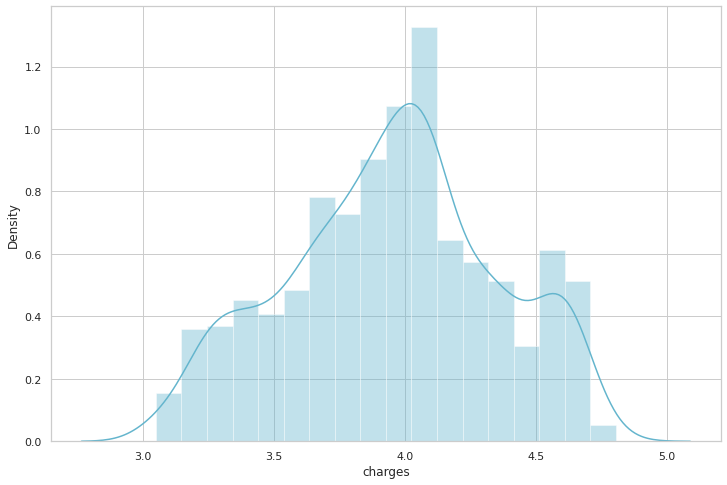

In [ ]:
# Видим, что данный график смещен, приведем его к нормальному распрделению (применим натуральный логарифм)
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.distplot(np.log10(data.charges), kde = True, color = 'c' )

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


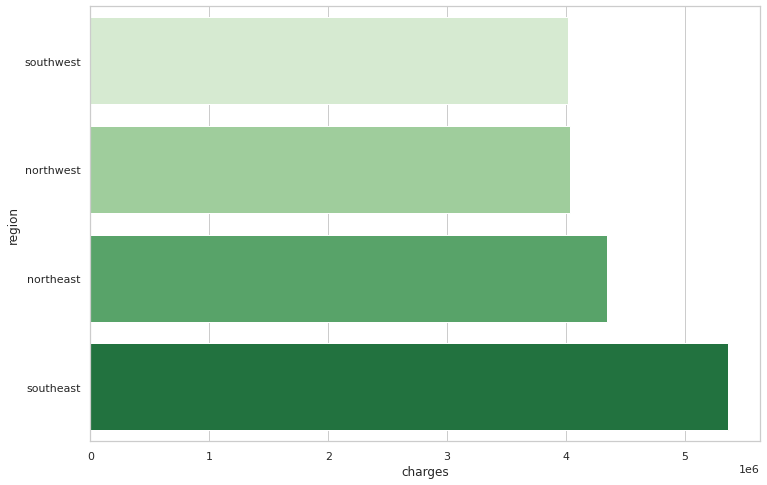

In [ ]:
# посмотрим, как зависит стоимость (charges) от регионов 
charges = data['charges'].groupby(data.region).sum().sort_values(ascending = True)
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(charges.head(), charges.head().index, palette='Greens')

Так, самая низкая стоимость страховых взносов на юго-западе, а самая высокая - на юго-востоке. Теперь посмотрим, как меняется стоимость взноса по регионам с учетом некоторых признаков - пол, курение, наличие детей. 

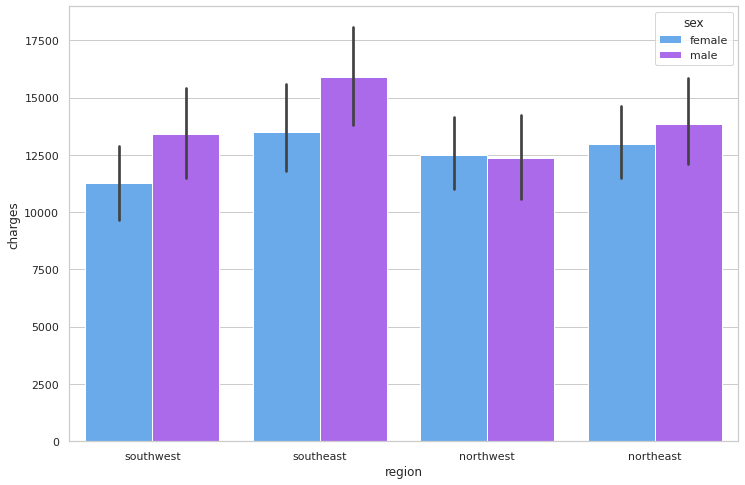

In [ ]:
# стоимость по регионам с учётом пола 
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='sex', data=data, palette='cool')

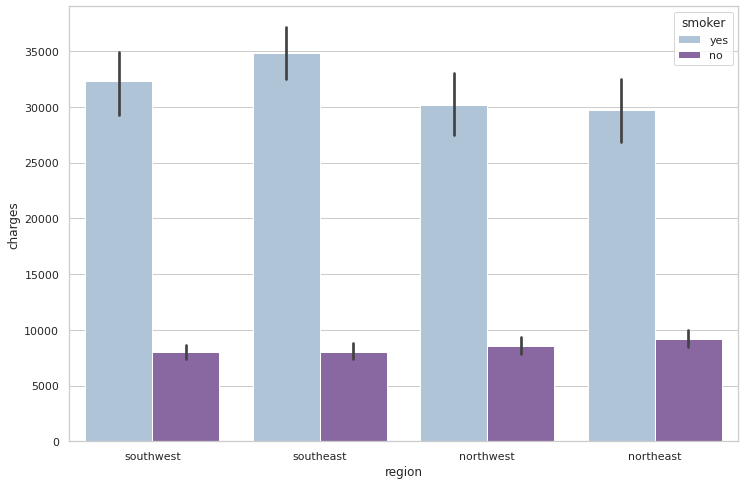

In [ ]:
# стоимость по регионам с учётом того, курит человек или нет 
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='smoker', data=data, palette='BuPu')

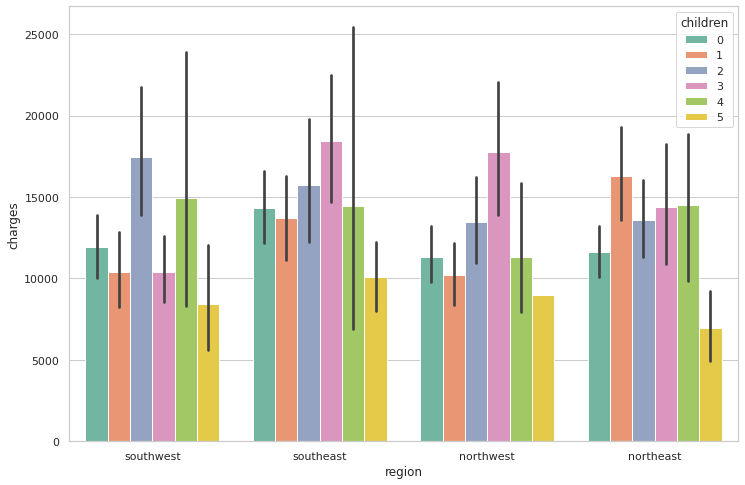

In [ ]:
# стоимость по регионам с учётом наличия детей
f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax = sns.barplot(x='region', y='charges', hue='children', data=data, palette='Set2')

Немного проанализируем графики, представленные выше. Можем заметить, что по-прежнему жители на юго-востоке имеют высокую стоимость страхового взноса с учетом всех признаков (пол, курение, наличие детей). Также видим, что жители на юго-западе курят больше, чем жители на северо-востоке, но жители на северо-востоке имееют стоимость взноса выше, чем жители на юго-западе и северо-западе в зависимости от пола. Судя по последней гистограмме, жители с детьми имеют высокие медицинские расходы. 

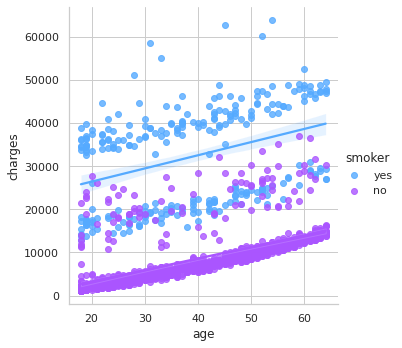

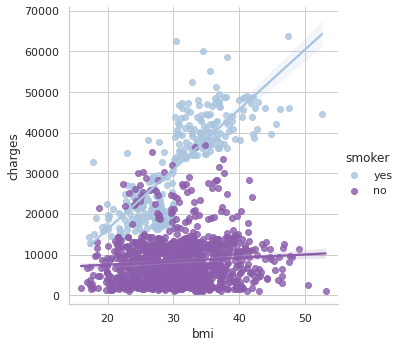

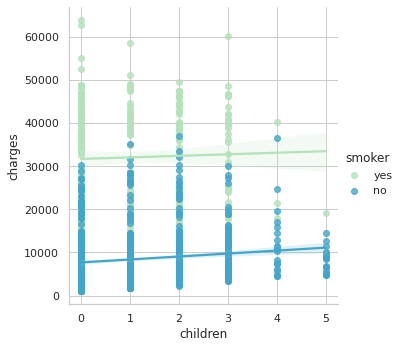

In [ ]:
# посмотрим, как влияют на стоимость взносов возраст, ИМТ и дети в зависимости от фактора курения 
ax = sns.lmplot(x = 'age', y = 'charges', data=data, hue='smoker', palette='cool')
ax = sns.lmplot(x = 'bmi', y = 'charges', data=data, hue='smoker', palette='BuPu')
ax = sns.lmplot(x = 'children', y = 'charges', data=data, hue='smoker', palette='GnBu')

Из графиков видим, что курение оказывает большое влияние на стоимость взносов, хотя расходы также растут с возрастом, ИМТ и детьми. А еще жители с детьми курят меньше, судя по последнему графику. 

In [ ]:
# преобразуем objects --> categorical
data[['sex', 'smoker', 'region']] = data[['sex', 'smoker', 'region']].astype('category')
data.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

In [ ]:
# закодируем категориальные признаки с помощью LabelEncoder
label = LabelEncoder()

label.fit(data.sex.drop_duplicates())
data.sex = label.transform(data.sex) 

label.fit(data.smoker.drop_duplicates())
data.smoker = label.transform(data.smoker) 

label.fit(data.region.drop_duplicates())
data.region = label.transform(data.region) 

data.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

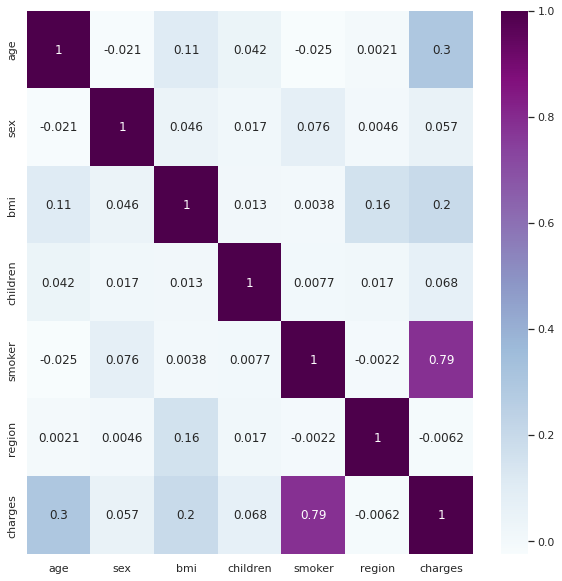

In [ ]:
# изобразим матрицу попарной корреляции признаков 
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(data.corr(), annot=True, cmap='BuPu')

Видим сильную корреляцию только между стоимостью страховых взносов и курением, в остальных случаях её нет. 

# Перейдём к обучению 

Linear Regression

In [ ]:
X = data.drop(['charges'], axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train) 

print(lin_reg.intercept_) 
print(lin_reg.coef_)
print(lin_reg.score(X_test, y_test))

-11661.98390882441
[  253.99185244   -24.32455098   328.40261701   443.72929547
 23568.87948381  -288.50857254]
0.799874714544996


Видим, что линейная регрессия дала нам достаточно неплохой результат. 

Ridge Regression

In [ ]:
Ridge = Ridge(alpha=0.5)
Ridge.fit(X_train, y_train)

print(Ridge.intercept_)
print(Ridge.coef_)
print(Ridge.score(X_test, y_test))

-11643.440927495825
[ 2.53893751e+02 -2.15112284e+01  3.28339566e+02  4.44238477e+02
  2.35009674e+04 -2.89027871e+02]
0.7996989632063141


Lasso Regression

In [ ]:
Lasso = Lasso(alpha=0.2, fit_intercept=True, normalize=False, precompute=False, max_iter=1000,
                 tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')
Lasso.fit(X_train, y_train) 

print(Lasso.intercept_)
print(Lasso.coef_)
print(Lasso.score(X_test, y_test))

-11661.83892903954
[ 2.53991436e+02 -2.34569821e+01  3.28389438e+02  4.43587436e+02
  2.35676136e+04 -2.88340296e+02]
0.7998690236224706


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  FutureWarning,


Random Forest Regressor 

In [ ]:
Rfr = RandomForestRegressor(n_estimators = 100, criterion = 'mse', random_state = 1, n_jobs = -1)

Rfr.fit(X_train,y_train)
y_train_pred = Rfr.predict(X_train)
y_test_pred = Rfr.predict(X_test) 

print('MSE train data: %.3f, MSE test data: %.3f' % 
      (metrics.mean_squared_error(y_train_pred, y_train),
       metrics.mean_squared_error(y_test_pred, y_test)))
print('R2 train data: %.3f, R2 test data: %.3f' % 
      (metrics.r2_score(y_train_pred, y_train),
       metrics.r2_score(y_test_pred, y_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


MSE train data: 3628893.887, MSE test data: 19730453.910
R2 train data: 0.972, R2 test data: 0.867


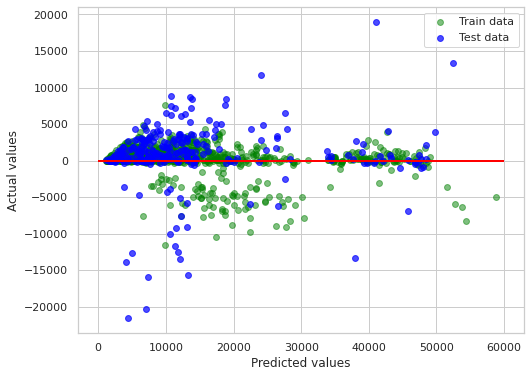

In [ ]:
plt.figure(figsize=(8,6))

plt.scatter(y_train_pred, y_train_pred - y_train, c = 'green', marker = 'o', s = 35, alpha = 0.5, label = 'Train data')
plt.scatter(y_test_pred, y_test_pred - y_test, c = 'blue', marker = 'o', s = 35, alpha = 0.7, label = 'Test data')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.legend(loc = 'upper right')
plt.hlines(y = 0, xmin = 0, xmax = 60000, lw = 2, color = 'red')

In [ ]:
# посмотрим, какие критерии являются самыми важными
importances = Rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in Rfr.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
variables = ['age', 'sex', 'bmi', 'children','smoker', 'region']
importance_list = []
for f in range(X.shape[1]):
    variable = variables[indices[f]]
    importance_list.append(variable)
    print("%d.%s(%f)" % (f + 1, variable, importances[indices[f]]))

1.smoker(0.601678)
2.bmi(0.218831)
3.age(0.136943)
4.children(0.020990)
5.region(0.015165)
6.sex(0.006393)


Так, самый важный фактор - курение, после идут ИМТ и возраст. Практически ничего не дают такие факторы, как регион и пол. 

Polynomial Regression

In [ ]:
# в этот раз не будем брать пол и регион, так как они почти ничего не значат 
X = data.drop(['charges', 'sex', 'region'], axis = 1)
y = data.charges

pol = PolynomialFeatures(degree = 2)
X_pol = pol.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_pol, y, test_size=0.2, random_state=0) 

Pol_reg = LinearRegression()
Pol_reg.fit(X_train, y_train) 
y_train_pred = Pol_reg.predict(X_train)
y_test_pred = Pol_reg.predict(X_test)

print(Pol_reg.intercept_)
print(Pol_reg.coef_)
print(Pol_reg.score(X_test, y_test))

-5325.88170525311
[ 0.00000000e+00 -4.01606591e+01  5.23702019e+02  8.52025026e+02
 -9.52698471e+03  3.04430186e+00  1.84508369e+00  6.01720286e+00
  4.20849790e+00 -9.38983382e+00  3.81612289e+00  1.40840670e+03
 -1.45982790e+02 -4.46151855e+02 -9.52698471e+03]
0.881259570334523


In [ ]:
# оценим параметры модели
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 2824.4950454776467
Mean Squared Error: 18895160.098780368
Root Mean Squared Error: 4346.8563466924425


In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_test_pred})
df

,Actual,Predicted
578,9724.53000,12101.156323
610,8547.69130,10440.782266
569,45702.02235,48541.022951
1034,12950.07120,14140.067522
198,9644.25250,8636.235727
...,...,...
1084,15019.76005,16712.196281
726,6664.68595,8654.565461
1132,20709.02034,12372.050609
725,40932.42950,41465.617268


Вывод: в данном примере рассмотрели задачу прогнозирования стоимости страховых взносов в зависимости от разных факторов. Выявили, что самым важным признаком является курение, а также не менее важными - возраст и индекс массы тела. Регион и пол практически никак не влияют на стоимость взноса. Лучшей моделью оказалась полиномиальная регрессия, ее точность составляет 0.88. 